# Generating Test Data

As a sanity check, it is often helpful to use test data with a known state sequence in order to make sure that the code
is working. The hdphmm package has functionality designed exactly for this. In this example, we will generate vector
autoregressive time series, use the HDPHMM to determine the latent state sequence, then compare the predictions to the
known state sequence.

Let's start by remembering exactly what a vector autoregressive timeseries looks like.


For a multidimensional time series, one could write a system of dependent autoregressive equations:

$Y_t = \phi_1 Y_{t-1} + ... + \phi_p Y_{t-p} + u_t$

where

$Y_t = \begin{bmatrix} y_{1,t} \\ y_{2,t} \\ ... \\  y_{k,t} \end{bmatrix},
 Y_{t-1} = \begin{bmatrix} y_{1,t-1} \\ y_{2,t-1} \\ ... \\  y_{k,t-1} \end{bmatrix},
 ...$

The matrices $\phi_i$ are K x K matrices where K is the number of dimensions of the trajectory.
$\phi_1$ contains the 1st time lag autoregressive coefficients. If

$\phi_1 = \begin{bmatrix} 0.5 & 0 \\ 0 & 0.4 \end{bmatrix}$

the associated system of equations for a VAR(1) process would be:

$y_{1,t} = 0.5y_{1,t-1} + u_{1,t}$

$y_{2,t} = 0.4y_{2, t-1} + u_{2,t}$

Of course, adding cross-terms to $\phi$ would create more complex dynamical behavior

$u_t$ is a K-dimensional vector multivariate gaussian noise generated on the covariance matrix of the data

In [44]:
"""
Let's start with importing the modules we will use.
"""

import hdphmm
from hdphmm import generate_timeseries as gent
import numpy as np
import matplotlib.pyplot as plt

First, we must initialize the parameters that we will use to describe the time series. At minimum, we must tell the program the type of dynamics, the dimensions of the trajectories and the number of states. It will assume an autoregressive order of 1 unless told otherwise.

In [12]:
dynamics = 'AR'  # the type of dynamics (AR = autoregressive)
dim = 2  # number of trajectory dimensions
nstates = 3  # number of independent states

trajectory_generator = gent.GenARData(dim=dim, nstates=nstates)

Based on this minimal set of inputs, the GenData class will create a transition matrix, a covariance matrix and autoregressive coefficient matrices ($\phi$). Note that for randomly generated parameters, the off-diagonals of $\phi$ are set to 0 for stability purposes.

In [14]:
print('T=\n', trajectory_generator.T)
print('cov=\n', trajectory_generator.cov)
print('Phi=\n', trajectory_generator.phis)
print('mu=\n', trajectory_generator.mu)

T=
 [[0.831  0.0819 0.0872]
 [0.1308 0.7837 0.0856]
 [0.07   0.1444 0.7856]]
cov=
 [[[0.87   0.6977]
  [0.6977 0.5767]]

 [[0.8539 0.3547]
  [0.3547 0.2167]]

 [[0.0781 0.0904]
  [0.0904 0.1123]]]
Phi=
 [[[[ 0.9754  0.    ]
   [ 0.      0.0097]]]


 [[[-0.499   0.    ]
   [ 0.     -0.5888]]]


 [[[-0.3884  0.    ]
   [ 0.      0.3714]]]]
mu=
 [[0. 0.]
 [0. 0.]
 [0. 0.]]


Automatic generation is nice, but maybe we want more control. Let's define the above parameters and pass them to the GenData class.

In [196]:
T = np.array([[0.99, 0.005, 0.005], [0.01, 0.98, 0.01], [0.02, 0.03, 0.95]])
cov = np.array([[[0.8, 0.16], [0.16, 0.06]], [[1, 0.35], [0.35, 0.13]], [[0.07, 0.223], [0.223, 0.9]]])
phis = np.array([[[0.1, 0], [0, -0.3]], [[-0.7, 0.0], [0.0, 0.2]], [[0.45, 0.0], [0.0, -0.2]]])
# phis = np.array([[[0.1, 0], [0, -0.3]], [[0.1, 0], [0, -0.3]], [[0.1, 0], [0, -0.3]]])
# cov = np.array([[[0.4, 0.16], [0.16, 0.2]], [[0.4, 0.16], [0.16, 0.2]], [[0.4, 0.16], [0.16, 0.2]]])
mu = np.array([[0, 3], [-2, 6], [1, 7]])

unconditional_mean = np.linalg.inv(np.eye(2) - phis[0]) @ mu[0]  # (inv(I - A1 - A2 ...)*c) where c is the mean of the gaussian noise

trajectory_generator = gent.GenARData(dim=dim, transition_matrix=T, phis=phis, cov=cov, mu=mu)
#print(trajectory_generator.mu)

Okay, now actually generate some trajectories

In [197]:
ntraj = 1  # generate 1 multi-dimensional trajectory
nsteps = 2000  # number of time steps in trajectory

trajectory_generator.gen_trajectory(nsteps, ntraj)

And now plot them to see what they look like. It is clear that the types of fluctuations are changing frequently. Note that each trajectory is just noise about 0. 

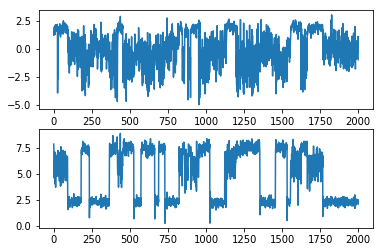

In [198]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(trajectory_generator.traj[:, 0, 0])
ax[1].plot(trajectory_generator.traj[:, 0, 1])

plt.show()

# Estimating the latent state sequnce with the HDPHMM

Now let's use the HDPHMM to estimate the latent state sequence and the AR parameters of the test data. We will first initialize the InfiniteHMM class using the trajectory_generator object. Then we will run the algorithm for a set number of iterations. 

Remember, we aren't providing the algorithm with anything other than the raw trajectory data.

In [199]:
niter = 100  # number of iterations to cycle through
ihmm = hdphmm.InfiniteHMM(trajectory_generator, max_states=10, prior='MNIW-N')
ihmm.inference(niter)

  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 1 2 dimensional trajectories assuming an autoregressive order of 1


100%|██████████| 100/100 [00:19<00:00,  4.69it/s]


Now it's time to see how the algorithm did.

[1, 2, 3]
Found 3 unique states
3 states were used to generate this data

Estimated Transition Matrix:

[[0.9918 0.0036 0.0046]
 [0.0159 0.9728 0.0113]
 [0.0043 0.0246 0.9711]]
Correctly identified 100.0 % of states


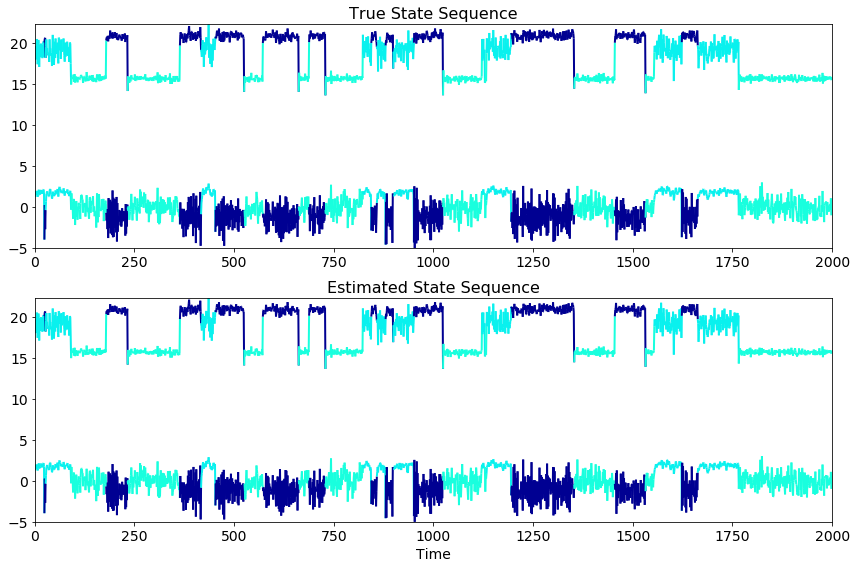

In [200]:
ihmm.summarize_results(traj_no=0)

Not bad! If you are generating trajectories using the same parameters as me, you should be getting about 96 % of the latent states correct. If you're not getting good results try calling the inference method again, perhaps with more iterations.

In [201]:
ihmm._get_params()

Found 3 unique states

Estimated Transition Matrix:

[[0.9728 0.0113 0.0159]
 [0.0246 0.9711 0.0043]
 [0.0036 0.0046 0.9918]]

Autoregressive parameters equilibrated after 75 iterations


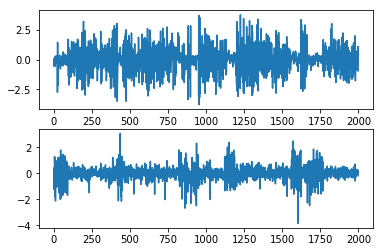

In [217]:
found_states = np.unique(ihmm.z[0, :])
map_state_to_ndx = {x:i for i, x in enumerate(found_states)}
state_sequence = np.array([map_state_to_ndx[i] for i in ihmm.z[0, :]])
traj = ihmm.trajectories[:, 0, :]

mu = ihmm.converged_params['mu'].mean(axis=0)
A = ihmm.converged_params['A'][:, 0, ...].mean(axis=0)

# important!
unconditional_mean = np.zeros_like(mu)
for i in range(len(found_states)):
    unconditional_mean[:, i] = np.linalg.inv(np.eye(2) - A[..., i]) @ mu[:, i]

diff = unconditional_mean[:, state_sequence].T
zeroed = traj - diff

fig, ax = plt.subplots(2, 1)
ax[0].plot(zeroed[:, 0])
ax[1].plot(zeroed[:, 1])
plt.show()

In [134]:
for i in range(3):
    print(np.round(ihmm.converged_params['mu'][..., i].mean(axis=0)))
#     print(ihmm.converged_params['sigma'][:, ..., i].mean(axis=0))
#     print(ihmm.converged_params['A'][:, 0, ..., i].mean(axis=0))

[-0.  3.]
[[0.8063 0.1508]
 [0.1508 0.0588]]
[[ 0.0508  0.0513]
 [-0.0116 -0.2833]]
[1. 7.]
[[0.0826 0.2281]
 [0.2281 0.9348]]
[[ 0.4044  0.017 ]
 [ 0.0632 -0.2077]]
[-1.  6.]
[[0.9628 0.3294]
 [0.3294 0.1238]]
[[-0.6792 -0.0862]
 [ 0.009   0.1574]]


[0, 4, 6]
[[0.7927 0.2738]
 [0.2738 0.1044]]
[[-0.0266  0.284 ]
 [-0.0147  0.1115]]


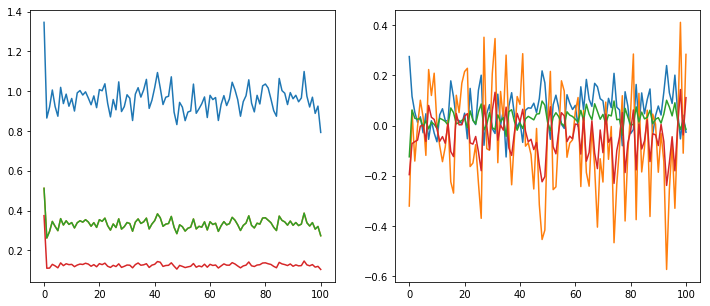

In [159]:
estimated_states = ihmm.z[0, :]  # estimated state sequence

found_states = list(np.unique(estimated_states))  # all of the states that were identified
print(found_states)

sigma = np.zeros([niter + 1, 2, 2])
A = np.zeros([niter + 1, 2, 2])

for a in range(niter + 1):
    A[a, ...] = ihmm.convergence['A'][a][..., found_states[0], 0]
    sigma[a, ...] = np.linalg.inv(ihmm.convergence['invSigma'][a][..., found_states[0], 0])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(4):
    ax[0].plot(sigma[:, i // 2, i % 2])
    ax[1].plot(A[:, i // 2, i % 2])

print(sigma[-1, ...])
print(A[-1, ...])
plt.show()